In [1]:
from google.colab import drive  
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
path = "/content/drive/My Drive/Khoa Luan/"

In [3]:
import pickle
import pandas as pd
df = pd.read_csv(path+"data3.csv")
df = df.dropna()

In [4]:
data = df.review.to_list()
label = df.label.to_list()

In [5]:
!pip install -q keras-bert==0.85.0
!pip install -q keras-rectified-adam

In [6]:
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [7]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [8]:
pip install keras==2.3.1

     |████████████████████████████████| 378kB 7.1MB/s 
ERROR: keras-bert 0.85.0 has requirement Keras>=2.4.3, but you'll have keras 2.3.1 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [9]:
import codecs
import tensorflow as tf
import keras
import os
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
import numpy as np

Using TensorFlow backend.


In [10]:
SEQ_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5

In [11]:
pretrained_path = 'multi_cased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [19]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    trainable=True,
    seq_len=SEQ_LEN,
    output_layer_num=4
)

In [13]:
token_dict = {}
with codecs.open(vocab_path, 'rb','utf-8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

In [14]:
from keras_bert import Tokenizer
tokenizer = Tokenizer(token_dict,cased=True)

In [15]:
from keras_bert.layers import Extract
from keras.regularizers import l1

In [20]:
inputs = model.inputs[:2]
newout = Extract(index=0)(model.output)
newout = keras.layers.Dense(768,activation='relu')(newout)
outputs = keras.layers.Dense(units=1, activation='sigmoid')(newout)
model = keras.models.Model(inputs, outputs)
model.compile(
  RAdam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

In [22]:
from sklearn.model_selection import train_test_split
def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
      ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
      indices.append(ids)

    return [indices, np.zeros_like(indices)], np.array(sentiments)

In [ ]:
data_train,data_valid,label_train,label_valid = train_test_split(data,label,test_size=0.15,random_state=48)

In [ ]:
X_train,Y_train = load_data(data_train,label_train)
X_valid,Y_valid = load_data(data_valid,label_valid)

In [23]:
test = pd.read_csv(path+'test3.csv')
test = test.dropna()
data_test = test.review.tolist()
label_test = test.label.tolist()
X_test,Y_test = load_data(data_test,label_test)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(path+'256_checkpoint_data1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
model.load_weights(path+'256_checkpoint_data1.h5')

In [ ]:
model.fit(X_train,Y_train,epochs=EPOCHS,batch_size=16,verbose = 1,validation_data=[X_valid,Y_valid],callbacks=callbacks_list)  

In [25]:
y_pred = np.round(model.predict(X_test))

In [26]:
from sklearn.metrics import precision_score,recall_score,f1_score
print(precision_score(Y_test,y_pred))
print(recall_score(Y_test,y_pred))
print(f1_score(Y_test,y_pred))

0.8608277640989564
0.884471750391519
0.8724896019013666


In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
cn = confusion_matrix(Y_test,y_pred,labels=labels)

In [30]:
#@title plot confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          target_names=None,
                          path_file='1.svg'):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_file,format='svg')
    plt.show()

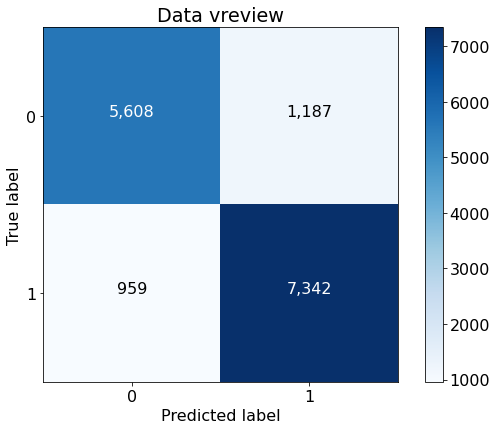

In [31]:
plot_confusion_matrix(cn,title='Data vreview',normalize=False,target_names=labels,path_file=path+'bert_base_vreview_cm.svg')

In [ ]:
for i in range(1000):
  if y_pred[i]!=Y_test[i]:
    print(y_pred[i],Y_test[i])
    print(data_test[i])

[0.] 1
da di han ngay mua gio roi moi chup feedback lai chan minh di nhung thay co ban bao co be nen lay vua positive in luon di luc bi negative ti vao got nhung minh thay da so giay nao moi di cung the so voi gia la qua dep positive roi
[0.] 1
phí giao hàng quá đắt
[1.] 0
chả có hộp hiếc đàng_hoàng gì có mỗi cây_son tưởng đóng_hộp đẹp positive lắm
[1.] 0
thoi gian giao hang rat nhanh dung ngua negative voi len mun
[1.] 0
chua hai long positive voi san pham
[0.] 1
không hổ_danh là đầu_đàn của android thích positive nhất dòng không của ss
[1.] 0
thật_sự là bị negative rảnh tiền tết quá nên mới mua quyển này đọc được positive một phần ba quyển thật_sự không muốn đọc tiếp nữa ngoài bìa có một câu nói khiến tôi rất tâm_đắc nên cứ nghĩ là truyện sẽ rất hay ai_ngờ lại làm tôi thất_vọng negative cách viết thật_sự quá chán negative hay có những câu mang tính triết_lý nhưng lại không hề triết_lý tí nào kiểu dùng từ hoa_mĩ một_cách tuỳ_tiện vậy tạm không xét đến lời_văn tôi chỉ muốn hỏi tại_sao 